# LSTM - Longer Version

Use a sine wave as the data.

The LSTM code is based on https://github.com/kratzert/ealstm_regional_modeling/blob/master/

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

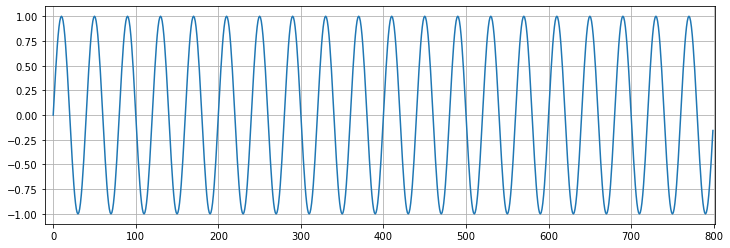

In [2]:
# Create & plot data points
x = torch.linspace(0,799,steps=800)
y = torch.sin(x*2*3.1416/40)

plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy())

## Divide the data into training set, test set, and further divide into batches

For this particular case, batch_size = 1 works best.

In [3]:
test_size = 40

train_set = torch.FloatTensor(y[:-test_size])
test_set = torch.FloatTensor(y[-test_size:])

def prepare_batches(vector, batch_size, seq_size):
    out_x = []
    out_y = []
    L = len(vector)
    for i in range(L-seq_size):
        if np.mod(i, batch_size) == 0:
            batch_x = []
            batch_y = []

        window = vector[i:i+seq_size]
        label = vector[i+seq_size:i+seq_size+1]
        batch_x.append(window)
        batch_y.append(label)

        if np.mod(i, batch_size) == (batch_size - 1):
            batch_x = torch.stack(batch_x)
            #batch_x = batch_x.reshape(*batch_x.shape, 1)
            out_x.append(batch_x)
            out_y.append(torch.FloatTensor(batch_y))

    return out_x, out_y

train_x, train_y = prepare_batches(train_set, batch_size=1, seq_size=12)
test_x, test_y = prepare_batches(test_set, batch_size=1, seq_size=12)

In [4]:
print(f'The size of a training batch is {train_x[0].detach().numpy().shape}')
print(f'The number of training batches is {len(train_x)}')

print(f'The size of a test batch is {test_x[0].detach().numpy().shape}')
print(f'The number of test batches is {len(test_x)}')

The size of a training batch is (1, 12)
The number of training batches is 748
The size of a test batch is (1, 12)
The number of test batches is 28


## Define the Model Structure

In [5]:
class LSTMLayer(nn.Module):
    """Implementation of the standard LSTM

    Parameters
    ----------
    input_size : int
        Number of input features
    hidden_size : int
        Number of hidden/memory cells.
    batch_first : bool, optional
        If True, expects the batch inputs to be of shape [batch, seq, features] otherwise, the
        shape has to be [seq, batch, features], by default True.
    initial_forget_bias : int, optional
        Value of the initial forget gate bias, by default 0
    """

    def __init__(self, input_size, hidden_size, batch_first = True,
                 initial_forget_bias = 0):
        super(LSTMLayer, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.initial_forget_bias = initial_forget_bias

        # create tensors of learnable parameters
        # Parameters are Tensor subclasses, that have a very special property when used with 
        # Module s - when they’re assigned as Module attributes they are automatically added 
        # to the list of its parameters, and will appear e.g. in parameters() iterator. 
        self.weight_ih = nn.Parameter(torch.FloatTensor(input_size, 4 * hidden_size))
        self.weight_hh = nn.Parameter(torch.FloatTensor(hidden_size, 4 * hidden_size))
        self.bias = nn.Parameter(torch.FloatTensor(4 * hidden_size))

        # initialize parameters
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize all learnable parameters of the LSTM"""

        # Fills the input Tensor with a (semi) orthogonal matrix
        nn.init.orthogonal_(self.weight_ih.data)

        weight_hh_data = torch.eye(self.hidden_size)
        weight_hh_data = weight_hh_data.repeat(1, 4)
        self.weight_hh.data = weight_hh_data
        nn.init.constant_(self.bias.data, val=0)

        if self.initial_forget_bias != 0:
            self.bias.data[:self.hidden_size] = self.initial_forget_bias

    def forward(self, x):
        """[summary]
        
        Parameters
        ----------
        x : torch.Tensor
            Tensor, containing a batch of input sequences. Format must match the specified format,
            defined by the batch_first agrument.
        Returns
        -------
        h_n : torch.Tensor
            The hidden states of each time step of each sample in the batch.
        c_n : torch.Tensor]
            The cell states of each time step of each sample in the batch.
        """
        if not self.batch_first:
            x = x.transpose(0, 1) # switch the 1st and 2nd dimension

        batch_size, seq_len = x.size()

        # reset the hidden state and cell state for each new batch of sequences
        h_0 = x.data.new(batch_size, self.hidden_size).zero_()
        c_0 = x.data.new(batch_size, self.hidden_size).zero_()
        h_x = (h_0, c_0)

        # empty lists to temporally store all intermediate hidden/cell states
        h_n, c_n = [], []

        # expand bias vectors to batch size
        bias_batch = (self.bias.unsqueeze(0).expand(batch_size, *self.bias.size()))

        # perform forward steps over input sequence
        for t in range(batch_size):
            h_0, c_0 = h_x

            # calculate gates
            gates = (torch.addmm(bias_batch, h_0, self.weight_hh) + \
                     torch.mm(x[[t], :], self.weight_ih))
            f, i, g, o = gates.chunk(4, 1)

            c_1 = torch.sigmoid(f) * c_0 + torch.sigmoid(i) * torch.tanh(g)
            h_1 = torch.sigmoid(o) * torch.tanh(c_1)

            # store intermediate hidden/cell state in list
            h_n.append(h_1)
            c_n.append(c_1)

            h_x = (h_1, c_1)

        h_n = torch.stack(h_n, 0)
        c_n = torch.stack(c_n, 0)

        if self.batch_first:
            h_n = h_n.transpose(0, 1)
            c_n = c_n.transpose(0, 1)

        return h_n, c_n

In [6]:
class LSTM(nn.Module):
    """Wrapper class that connects LSTM with fully connceted layer. """

    def __init__(self, input_size, out_size, hidden_size, initial_forget_bias = 5,
                 dropout = 0.0):
        """Initialize model.
        Parameters
        ----------
        input_size: int
            Number of input features.
        hidden_size: int
            Number of LSTM cells/hidden units.
        initial_forget_bias: int
            Value of the initial forget gate bias. (default: 5)
        dropout: float
            Dropout probability in range(0,1). (default: 0.0)
        """
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.initial_forget_bias = initial_forget_bias
        self.dropout_rate = dropout

        self.lstm = LSTMLayer(input_size=input_size,
                              hidden_size=hidden_size,
                              initial_forget_bias=initial_forget_bias)

        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x) :
        """Run forward pass through the lstm layer, the dropout layer, 
           and the fully connected layer.
        Parameters
        ----------
        x : torch.Tensor
            Tensor containing the input features of shape [batch, seq_length, n_features]

        Returns
        -------
        out : torch.Tensor
            Tensor containing the network predictions
        h_n : torch.Tensor
            Tensor containing the hidden states of each time step
        c_n : torch,Tensor
            Tensor containing the cell states of each time step
        """
        h_n, c_n = self.lstm(x)
        last_h = self.dropout(h_n[:, -1, :])
        out = self.fc(last_h)
        return out

## Other preparations

In [9]:
torch.manual_seed(42)
model = LSTM(input_size = 12, hidden_size = 1, out_size = 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

## Train and simultaneously evaluate the model

Epoch:  1 Loss: 0.00295396
Loss on test predictions: 0.05024789646267891


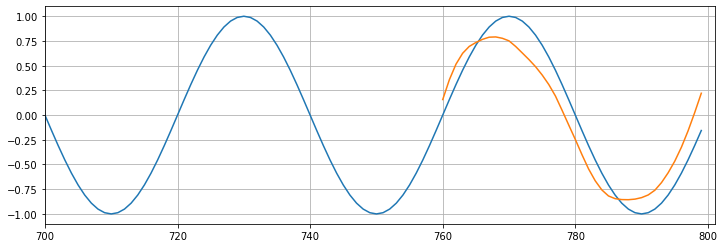

Epoch:  2 Loss: 0.00001982
Loss on test predictions: 0.0009422634029760957


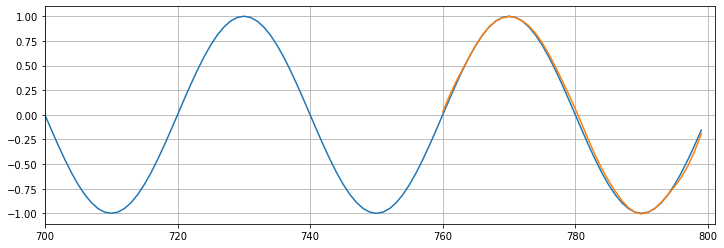

Epoch:  3 Loss: 0.00058671
Loss on test predictions: 0.14411859214305878


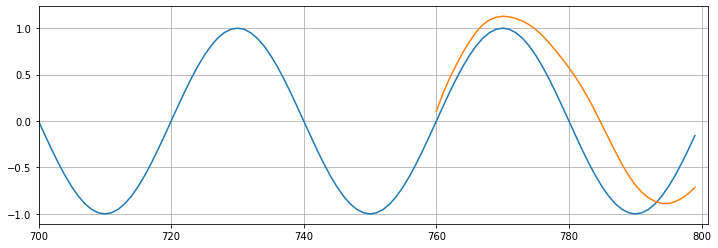

Epoch:  4 Loss: 0.00005549
Loss on test predictions: 0.012988537549972534


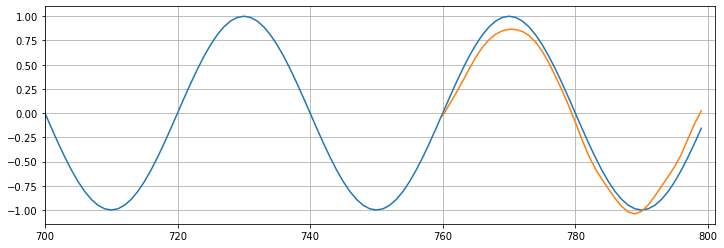

Epoch:  5 Loss: 0.00040673
Loss on test predictions: 0.17849932610988617


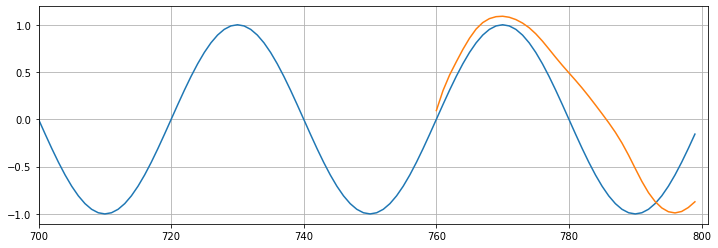

Epoch:  6 Loss: 0.01228765
Loss on test predictions: 0.011885151267051697


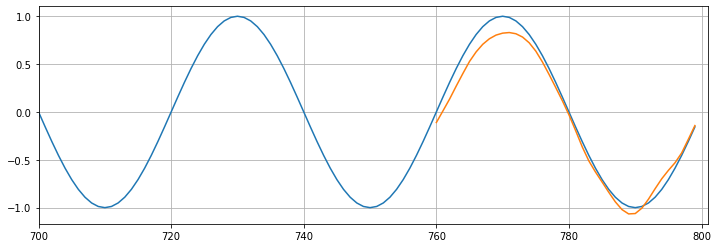

Epoch:  7 Loss: 0.01611051
Loss on test predictions: 0.039184197783470154


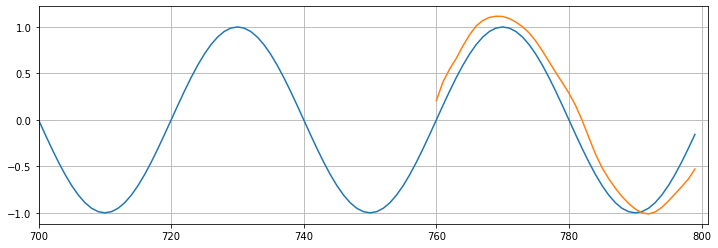

Epoch:  8 Loss: 0.01210541
Loss on test predictions: 0.01672830618917942


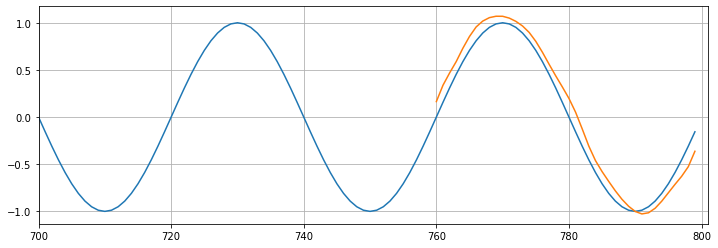

Epoch:  9 Loss: 0.01480100
Loss on test predictions: 0.011846394278109074


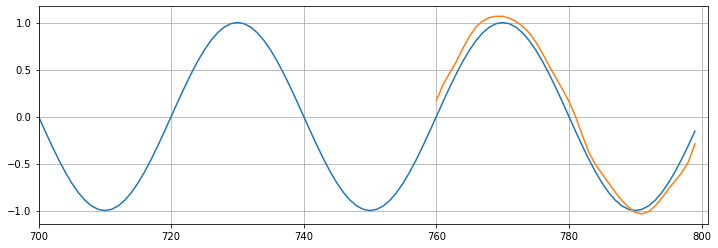

Epoch: 10 Loss: 0.01184424
Loss on test predictions: 0.0030685376841574907


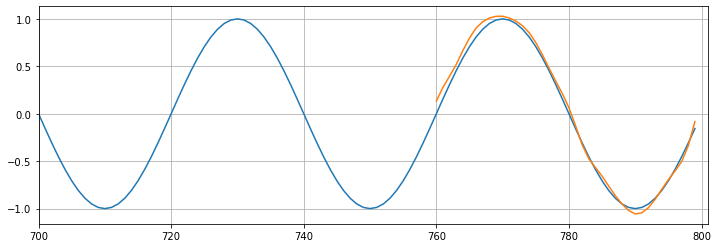

In [10]:
epochs = 10
future = 40
seq_len = 12

for i in range(epochs):

    # tuple-unpack the train_data set
    for batch_x, batch_y in zip(train_x, train_y):
        y_pred = model(batch_x)

        loss = criterion(y_pred, batch_y.view(-1,1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print training result
    print(f'Epoch: {i+1:2} Loss: {loss.item():10.8f}')

    # MAKE PREDICTIONS
    # start with the last training batch
    preds = torch.cat(train_y[-seq_len:])

    for f in range(future):  
        seq = preds[-seq_len:].reshape(1, seq_len)
        with torch.no_grad():
            preds = torch.cat((preds, torch.tensor([model(seq)])))

    loss = criterion(preds[-future:],y[760:])
    print(f'Loss on test predictions: {loss}')

    # Plot from point 700 to the end
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[-future:])
    plt.show()
